<a href="https://colab.research.google.com/github/OdinTech3/MSBA/blob/master/%5BCS59995%5D_RetailRocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !mkdir data; mv events.csv data/
# !pip install cytoolz plotnine humanize implicit

In [0]:
import os
import math
import humanize
import cytoolz as tlz
import pandas as pd
import numpy as np
from plotnine import *
from datetime import datetime, timedelta
from collections import Counter
from scipy.sparse import csr_matrix, coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

## Load The Dataset

In [0]:
# Run this if using local data
events_df = pd.read_csv("data/events.csv")
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


## Exploratory Data Analysis

In [0]:
unique_visitors = events_df["visitorid"].unique()
unique_items = events_df["itemid"].unique()

print("Total number of actions by visitor (records):", humanize.intword(events_df["visitorid"].size))
print("Total number of unique visitors:", humanize.intword(unique_visitors.size))
print("Total number of unique items:", humanize.intcomma(unique_items.size))

Total number of actions by visitor (records): 2.8 million
Total number of unique visitors: 1.4 million
Total number of unique items: 235,061


In [0]:
event_count = Counter(events_df["event"].values)
event_count_df = (
    pd.DataFrame
    .from_dict(event_count, orient='index')
    .reset_index()
    .rename(columns={'index':'event', 0:'count'})
)

event_count_df

,event,count
0,view,2664312
1,addtocart,69332
2,transaction,22457


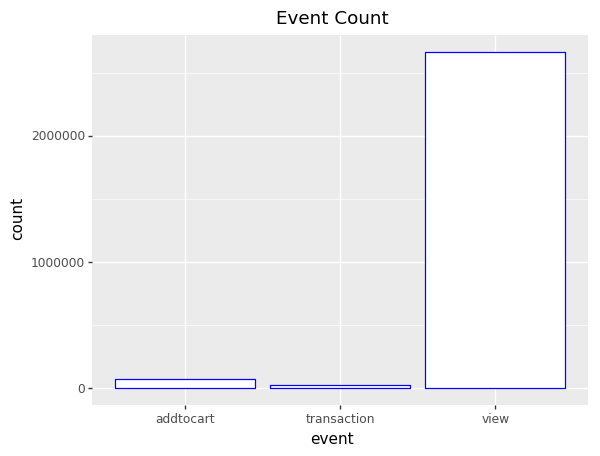

<ggplot: (-9223363258417342576)>

In [0]:
(
    ggplot(event_count_df, aes(x="event", y="count"))
    + geom_bar(stat="identity", fill="white", color="blue")
    + ggtitle("Event Count")
)

In [0]:
visitors_who_bought = events_df.loc[lambda df: df.transactionid.notnull()].visitorid.unique()

print("Number of visitors that made at least 1 purchase:", humanize.intcomma(visitors_who_bought.size))

Number of visitors that made at least 1 purchase: 11,719


Let's take a look into the distribution of  interactions: `events`, `addtocart`, and  `transaction` for each user. First we will convert the `event` column to a categorical column

In [0]:
events_df["event"] =  events_df["event"].astype("category")

events_df.event.describe()

count     2756101
unique          3
top          view
freq      2664312
Name: event, dtype: object

In [0]:
interaction_df = (
    events_df
    .loc[:, ["visitorid", "event"]]
    .groupby("visitorid")
    .count()
    .rename(columns={"event": "interactions"})
)

interaction_df.describe()

,interactions
count,1.407580e+06
mean,1.958042e+00
std,1.258049e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,7.757000e+03


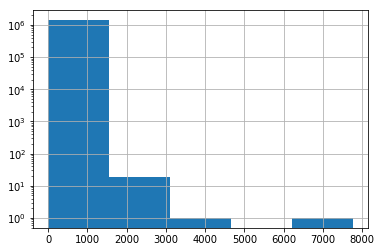

In [0]:
interaction_df.interactions.hist(bins=5, log=True)

`interaction_df` is a dataframe that has count of total interactions for each user.

## Building The Model

### Cleaning The Data


Removing rows whose visitors had less than 10 total interactions

In [0]:
less10 = interaction_df.loc[lambda df: df["interactions"] < 10].index.values
greater10_df = (
    events_df
    .loc[lambda df: ~df["visitorid"].isin(less10)]
    .reset_index(drop=True)
)

greater10_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433224214164,992329,view,248676,NaN
1,1433223203944,125625,view,17655,NaN
2,1433222147345,1076270,view,262799,NaN
3,1433224644638,361387,view,43485,NaN
4,1433224303386,503970,view,448136,NaN


We will create a function `to_datetime` that will convert the timestamps in `events_df` to datetime object with format: __year, month and day__

In [0]:
def to_datetime(timestamps: pd.Series) -> pd.Series:
  dates = [
      datetime.fromtimestamp(t / 1000).date()
      for t in timestamps
  ]
  return pd.Series(dates)

In [0]:
data_df = (
    greater10_df
    .loc[:, ["timestamp", "visitorid", "itemid", "event"]]
    .assign(date = lambda df: to_datetime(df["timestamp"]))
    .sort_values("timestamp", ascending=False)
    .reset_index(drop=True)
)

data_df.head()

,timestamp,visitorid,itemid,event,date
0,1442545037312,1063469,38888,view,2015-09-18
1,1442545004475,1100093,465387,view,2015-09-18
2,1442544741219,994820,89323,view,2015-09-18
3,1442544701919,994820,440677,view,2015-09-18
4,1442544674798,1100093,49907,view,2015-09-18


### Splitting into Training and Test

We will use the last days for testing

In [0]:
N_DAYS = 1
end_date = tlz.first(data_df.date.values)
start_date = end_date - timedelta(days = N_DAYS)

print("Start date for test data: ", start_date)
print("End date for test data: ", end_date)

Start date for test data:  2015-09-17
End date for test data:  2015-09-18


#### Previewing The Training Data

In [0]:
train_df = data_df[~data_df["date"].between(start_date, end_date)].reset_index(drop=True)

print("Shape of train dataset: ", train_df.shape)

Shape of train dataset:  (581075, 5)


In [0]:
train_df.head()

,timestamp,visitorid,itemid,event,date
0,1442447846473,765650,417578,view,2015-09-16
1,1442447729071,623174,427319,view,2015-09-16
2,1442447724456,565978,354403,view,2015-09-16
3,1442447696602,156163,226450,view,2015-09-16
4,1442447674802,565978,250408,view,2015-09-16


#### Previewing The Testing Data

In [0]:
test_df = data_df[data_df["date"].between(start_date, end_date)].reset_index(drop=True)

print("Shape of test dataset: ", test_df.shape)

Shape of test dataset:  (2229, 5)


In [0]:
test_df.head()

,timestamp,visitorid,itemid,event,date
0,1442545187788,1287495,98299,view,2015-09-18
1,1442545181778,622226,345308,view,2015-09-18
2,1442545174109,255126,47467,view,2015-09-18
3,1442545165499,1207677,310922,view,2015-09-18
4,1442545164029,472345,301436,view,2015-09-18


### Creating The User-Item Matrix

We create a function `encode_event` to encode the category of events as confidence points / ratings that shows how strong the interaction between the visitor and item was.

In order words items that were bought (**transacted**) by visitor carry more weight in our matrix compared to items that were viewed.

Items that were **added to the cart** carry a slightly lower weight than those that were bought.

In [0]:
def encode_event(event: str) -> int:
  if event == "transaction":
      return 4    
  elif event == "addtocart":  
      return 3
  else: 
      return 1

In [0]:
def calc_sparsity(m: csr_matrix) -> int:
  row, col = m.shape 
  matrix_size = row * col # Number of possible interactions in the matrix
  num_purchases = len(m.nonzero()[0]) # Number of items interacted with
  sparsity = 100 * (1 - (num_purchases / matrix_size))
  return sparsity

#### Creating The Training User-Item Matrix

The **implicit** library expects data as a item-user matrix so we create two matricies. One  for fitting/training the model (item-user) which we have named  `itemuser_matrix_train`  and one for recommendations (user-item) which we have name  `useritem_matrix_test`.

In [0]:
train_df['visitor'] = train_df['visitorid'].astype("category")
train_df['item'] = train_df['itemid'].astype("category")
train_df['visitor_id'] = train_df['visitor'].cat.codes
train_df['item_id'] = train_df['item'].cat.codes
train_df["event"] = train_df["event"].apply(encode_event)

train_df.head()

,timestamp,visitorid,itemid,event,date,visitor,item,visitor_id,item_id
0,1442447846473,765650,417578,1,2015-09-16,765650,417578,12682,68932
1,1442447729071,623174,427319,1,2015-09-16,623174,427319,10249,70446
2,1442447724456,565978,354403,1,2015-09-16,565978,354403,9302,58484
3,1442447696602,156163,226450,1,2015-09-16,156163,226450,2551,37360
4,1442447674802,565978,250408,1,2015-09-16,565978,250408,9302,41370


In [0]:
itemuser_df_train = train_df.loc[:, ["item_id", "visitor_id", "event"]]

itemuser_matrix_train = csr_matrix(
    (
        itemuser_df_train["event"].astype(float),
        (itemuser_df_train["item_id"], itemuser_df_train["visitor_id"])
    )
)

print("Shape of Training User-Item matrix: ", itemuser_matrix_train.shape)

Shape of Training User-Item matrix:  (76927, 23205)


In [0]:
print("Sparsity of Training User-Item matrix: ", calc_sparsity(itemuser_matrix_train))

Sparsity of Training User-Item matrix:  99.98226863539203


#### Creating The Test User-Item Matrix

In [0]:
test_df['visitor'] = test_df['visitorid'].astype("category")
test_df['item'] = test_df['itemid'].astype("category")
test_df['visitor_id'] = test_df['visitor'].cat.codes
test_df['item_id'] = test_df['item'].cat.codes
test_df["event"] = test_df["event"].apply(encode_event)

test_df.head()

,timestamp,visitorid,itemid,event,date,visitor,item,visitor_id,item_id
0,1442545037312,1063469,38888,1,2015-09-18,1063469,38888,223,99
1,1442545004475,1100093,465387,1,2015-09-18,1100093,465387,230,1324
2,1442544741219,994820,89323,1,2015-09-18,994820,89323,211,228
3,1442544701919,994820,440677,1,2015-09-18,994820,440677,211,1245
4,1442544674798,1100093,49907,1,2015-09-18,1100093,49907,230,133


In [0]:
useritem_df_test = test_df.loc[:, ["item_id", "visitor_id", "event"]]

useritem_matrix_test = csr_matrix(
    (
        useritem_df_test["event"].astype(float),
        (useritem_df_test["visitor_id"], useritem_df_test["item_id"])
    )
)

print("Shape of Training User-Item matrix: ", useritem_matrix_test.shape)

Shape of Training User-Item matrix:  (311, 1329)


In [0]:
print("Sparsity of Testing User-Item matrix: ", calc_sparsity(useritem_matrix_test))

Sparsity of Testing User-Item matrix:  99.63514863821891


### Building The Recommendation System using ALS

In [0]:
os.environ["OPENBLAS_NUM_THREADS"] = '1'

ALPHA = 15
train_matrix = (itemuser_matrix_train * ALPHA).astype('double')
als_model = AlternatingLeastSquares(
    factors=100,
    regularization=0.1,
    use_gpu=True,
)

als_model.fit(train_matrix)

GPU training requires factor size to be a multiple of 32. Increasing factors from 100 to 128.
100%|██████████| 15.0/15 [00:00<00:00, 18.21it/s]


Below is a preview of the recommendations with `visitor_id` 223

In [0]:
als_model.recommend(223, useritem_matrix_test, filter_already_liked_items=False)

[(64486, 0.405195),
 (16311, 0.38029155),
 (26115, 0.36960763),
 (66642, 0.36379844),
 (68136, 0.36287534),
 (43035, 0.32111767),
 (27665, 0.30785263),
 (60677, 0.3070662),
 (10538, 0.29619104),
 (43029, 0.29553646)]

### Building The Recommendation System using BPR

In [187]:
os.environ["OPENBLAS_NUM_THREADS"] = '1'

ALPHA = 15
train_matrix = (itemuser_matrix_train * ALPHA).astype('double')
bpr_model = BayesianPersonalizedRanking(
    factors=20,
    regularization=0.1,
    use_gpu=True,
)

bpr_model.fit(train_matrix)

GPU training requires factor size to be a multiple of 32 - 1. Increasing factors from 20 to 31.
100%|██████████| 100/100 [00:01<00:00, 96.24it/s, correct=67.92%, skipped=1.13%]


## Defining the Evaluation ( ALS & Top-K Hit Ratio )

In [0]:
from typing import List, Tuple

def calc_hit_ratio(items_of_user: pd.Series, top_k: List[Tuple[int, int]]) -> float:
    k = len(top_k)
    k_item_ids = {item_id for item_id, _ in top_k}
#     print("top K item ids:", k_item_ids)
    actual_items_ids = set(items_of_user)
#     print("actual item ids:", actual_items_ids)
    in_common = actual_items_ids.intersection(k_item_ids)
#     print("in common:", in_common)
    
    return len(in_common) / k    
  
def calc_topk_hit_ratio(
    k: int,
    model: AlternatingLeastSquares,
    user_item: pd.DataFrame,
    user_item_matrix: csr_matrix
) -> float:
    
    hit_ratios = []
    
    for row in user_item.itertuples():
#       print("Visitor id:", row.visitor_id)
      items_of_user = (
          user_item
          .loc[lambda df: df["visitor_id"] == row.visitor_id]
          .item_id
      )
      
      top_k = model.recommend(
          row.visitor_id,
          user_item_matrix,
          N=k,
          filter_already_liked_items=False
      )
      
      hit_ratios.append(calc_hit_ratio(items_of_user, top_k))
      
    
    return np.average(hit_ratios)

### Top-K Hit Ratio when k = 10

In [178]:
print("Avg Hit Ratio (ALS), k = 10: ", calc_topk_hit_ratio(10, als_model, useritem_df_test, useritem_matrix_test))

Avg Hit Ratio (ALS), k = 10:  0.07196052041274115


### Top-K Hit Ratio when k = 50

In [179]:
print("Avg Hit Ratio ALS, k = 50: ", calc_topk_hit_ratio(50, als_model, useritem_df_test, useritem_matrix_test))

Avg Hit Ratio ALS, k = 50:  0.025518169582772542


### Top-K Hit Ratio when k = 100

In [180]:
print("Avg Hit Ratio ALS, k = 100: ", calc_topk_hit_ratio(100, als_model, useritem_df_test, useritem_matrix_test))

Avg Hit Ratio ALS, k = 100:  0.0169537909376402


## Defining The Evaluation (ALS & nDCG)

In [0]:
def get_dcg_value(relevance_score: int, position: int) -> float:
    top = (2**relevance_score) - 1
    bottom = math.log(position + 1, 2)
    
    if top == 0 or bottom == 0:
        return 0
    
    return top / bottom

def calc_relevance_score(recommended_item_id: int, user_interacted_items: List[Tuple[int, int]]) -> int:
  
    found_item = [item for item in user_interacted_items if item[0] == recommended_item_id]
    
    if not found_item:
        return 0
    
    return user_interacted_items[0][1]   
  
def calc_ndcg(recommended_items: List[int], user_interacted_items: List[Tuple[int, int]]) -> float:
    scores = []
    for item in recommended_items:
        scores.append(calc_relevance_score(item, user_interacted_items))
    
    dcg = 0
    for i, s in enumerate(scores):
        dcg += get_dcg_value(s, i)
    
    idcg = 0
    scores.sort()
    for i, s in enumerate(scores):
        idcg += get_dcg_value(s, i)
        
    if dcg == 0 or idcg == 0:
        return 0
    
    return dcg / idcg

### nDCG for top-k when k = 10

In [181]:
k_10_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_10 = als_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      recalculate_user=True,
      N=10,
      filter_already_liked_items=False
  )

  top_10_itemids = [itemid for itemid, _ in top_k_10]

  k_10_ndcg.append(calc_ndcg(top_10_itemids, item_score))

print("Avg nDCG (ALS), k = 10: ", np.average(k_10_ndcg))

Avg nDCG (ALS), k = 10:  0.591857509259624


### nDCG for top-k when k = 50

In [183]:
k_50_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_50 = als_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      N=50,
      recalculate_user=True,
      filter_already_liked_items=False
  )

  top_50_itemids = [itemid for itemid, _ in top_k_50]

  k_50_ndcg.append(calc_ndcg(top_50_itemids, item_score))

print("Avg nDCG (ALS), k = 50: ", np.average(k_50_ndcg))

[0, 1.9866924784370925, 1.0466476186905076, 1.0466476186905076, 1.9866924784370925, 0.548736077839591, 0.548736077839591, 1.9866924784370925, 0.548736077839591, 2.183341610642396, 0, 1.0466476186905076, 0.548736077839591, 0, 0, 0.548736077839591, 0, 0, 0, 0, 0.548736077839591, 0, 0.548736077839591, 0, 0, 0, 0, 1.0466476186905076, 0.548736077839591, 0, 0.548736077839591, 0, 5.643856189774724, 0.548736077839591, 5.643856189774724, 0.548736077839591, 1.0466476186905076, 1.9866924784370925, 1.9866924784370925, 1.9866924784370925, 0, 0, 0, 0, 0, 1.9866924784370925, 2.183341610642396, 0, 0, 0, 0, 1.0466476186905076, 0, 1.0466476186905076, 2.183341610642396, 1.0466476186905076, 1.0466476186905076, 1.0678196201668901, 1.410964047443681, 1.0678196201668901, 1.0678196201668901, 1.0678196201668901, 1.0678196201668901, 1.0678196201668901, 0.548736077839591, 1.0466476186905076, 0.548736077839591, 0.548736077839591, 0.548736077839591, 0.548736077839591, 0.548736077839591, 5.643856189774724, 0.548736

### nDCG for top-k when k = 100

In [185]:
k_100_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_100 = als_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      N=100,
      recalculate_user=True,
      filter_already_liked_items=False
  )

  top_100_itemids = [itemid for itemid, _ in top_k_100]

  k_100_ndcg.append(calc_ndcg(top_100_itemids, item_score))

print("Avg nDCG (ALS), k = 100: ", np.average(k_100_ndcg))

Avg nDCG (ALS), k = 100:  1.4359685981762444


## Defining the Evaluation ( BPR & Top-K Hit Ratio )

### Top-K Hit Ratio when k = 10

In [190]:
print("Hit Ratio BPR, k = 10: ", calc_topk_hit_ratio(10, bpr_model, useritem_df_test, useritem_matrix_test))

Hit Ratio BPR, k = 10:  0.0


### Top-K Hit Ratio when k = 50

In [191]:
print("Hit Ratio BPR, k = 50: ", calc_topk_hit_ratio(50, bpr_model, useritem_df_test, useritem_matrix_test))

Hit Ratio BPR, k = 50:  0.00021534320323014807


### Top-K Hit Ratio when k = 100

In [192]:
print("Hit Ratio BPR, k = 100: ", calc_topk_hit_ratio(100, bpr_model, useritem_df_test, useritem_matrix_test))

Hit Ratio BPR, k = 100:  0.00018842530282637957


## Defining The Evaluation (BPR & nDCG)

### nDCG for top-k when k = 10

In [196]:
k_10_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_10 = bpr_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      N=10,
      filter_already_liked_items=False
  )

  top_10_itemids = [itemid for itemid, _ in top_k_10]

  k_10_ndcg.append(calc_ndcg(top_10_itemids, item_score))

print("Avg nDCG (BPR), k = 10: ", np.average(k_10_ndcg))

Avg nDCG (BPR), k = 10:  0.0


### nDCG for top-k when k = 50

In [197]:
k_50_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_50 = bpr_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      N=50,
      filter_already_liked_items=False
  )

  top_50_itemids = [itemid for itemid, _ in top_k_50]

  k_50_ndcg.append(calc_ndcg(top_50_itemids, item_score))

print("Avg nDCG (BPR), k = 50: ", np.average(k_50_ndcg))

Avg nDCG (BPR), k = 50:  0.011435027418399473


### nDCG for top-k when k = 100

In [198]:
k_100_ndcg = []
    
for row in useritem_df_test.itertuples():

  item_score: List[Tuple[int, int]]  = list(
      useritem_df_test
      .loc[lambda df: df["visitor_id"] == row.visitor_id]
      .loc[:, ["item_id", "event"]]
      .to_records(index=False)
  )

  top_k_100 = bpr_model.recommend(
      row.visitor_id,
      useritem_matrix_test,
      N=100,
      filter_already_liked_items=False
  )

  top_100_itemids = [itemid for itemid, _ in top_k_100]

  k_100_ndcg.append(calc_ndcg(top_100_itemids, item_score))

print("Avg nDCG (BPR), k = 100: ", np.average(k_100_ndcg))

Avg nDCG (BPR), k = 100:  0.022274587208177165
